# Estimation de la consommation réelle
**Structure :**
1. Chargement & Nettoyage (Focus Électricité)
2. Analyse Exploratoire (Scatter plots, Ratios)
3. Modélisation Statistique (Ajustement Historique)
4. Simulation Monte Carlo et Calibrage du Bruit
5. Intervalle de Confiance Personnalisé

## Chargement & Préparation des données

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Configuration Esthétique : Couleurs Foncées
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003f5c', '#bc5090', '#ffa600'])
plt.style.use('seaborn-v0_8-whitegrid')

cols_to_use = [
    "Consommation annuelle moyenne par logement de l'adresse (MWh)",
    "conso_5 usages_ef",
    "etiquette_dpe",
    "type_energie_n1"
]

try:
    df = pd.read_csv("fusion_dpe_conso.csv", usecols=cols_to_use)

    df = df.rename(columns={
        "Consommation annuelle moyenne par logement de l'adresse (MWh)": "C_real_MWh",
        "conso_5 usages_ef": "C_th_elec",
        "etiquette_dpe": "DPE",
        "type_energie_n1": "Energie_Principale"
    })

    # On ne garde que l'électricité
    df = df[df["Energie_Principale"] == "Électricité"].copy()

    # Conversion MWh → kWh
    df["C_real_elec"] = df["C_real_MWh"] * 1000
    df.drop(columns=["C_real_MWh"], inplace=True)

    # Nettoyage
    df = df.dropna()
    df = df[(df["C_real_elec"] > 100) & (df["C_th_elec"] > 100)]
    df = df[(df["C_real_elec"] < 100000) & (df["C_th_elec"] < 100000)]

    print(f"Dataset final : {len(df)} lignes")
    display(df.head())
except Exception as e:
    print(f"Erreur chargement : {e}")

Dataset final : 92259 lignes


,DPE,C_th_elec,Energie_Principale,C_real_elec
2,D,3640.4,Électricité,1594.0
5,D,2794.1,Électricité,2861.0
6,F,9042.7,Électricité,4393.0
9,D,1770.9,Électricité,2409.0
11,C,5116.1,Électricité,3338.0


## Analyse exploratoire
Visualisons la relation brute entre le théorique et le réel.

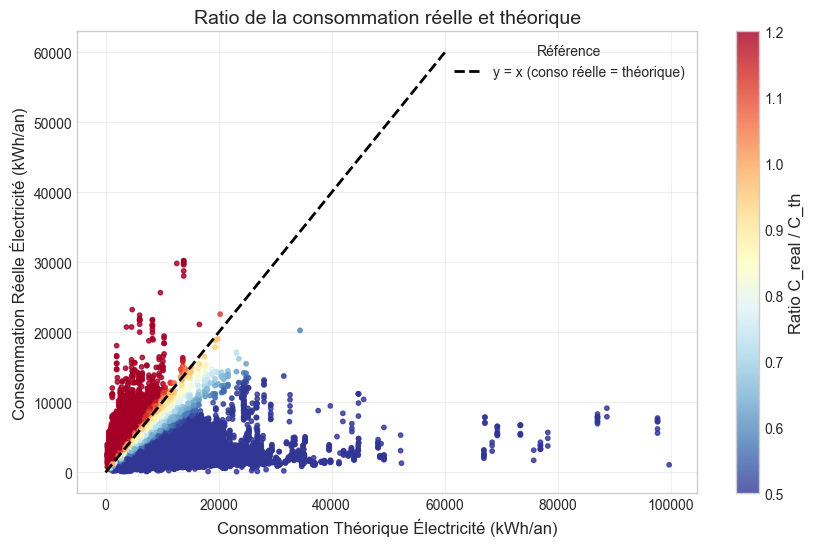

In [28]:
import matplotlib.pyplot as plt

# Calcul du ratio
ratio = df["C_real_elec"] / df["C_th_elec"]

plt.figure(figsize=(10, 6))

# Scatter plot avec cmap plus contrasté
sc = plt.scatter(
    df["C_th_elec"],
    df["C_real_elec"],
    c=ratio,
    cmap="RdYlBu_r",  # palette plus contrastée
    s=10,
    alpha=0.8,
    vmin=0.5,  # min ratio pour meilleure lisibilité
    vmax=1.2   # max ratio
)

# Droite d'identité
plt.plot([0, 60000], [0, 60000], 'k--', linewidth=2, label="y = x (conso réelle = théorique)")

# Barre de couleur
cbar = plt.colorbar(sc)
cbar.set_label("Ratio C_real / C_th", fontsize=12)

# Titres et axes
plt.xlabel("Consommation Théorique Électricité (kWh/an)", fontsize=12)
plt.ylabel("Consommation Réelle Électricité (kWh/an)", fontsize=12)
plt.title("Ratio de la consommation réelle et théorique", fontsize=14)

# Légende
plt.legend(title="Référence", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()



- 60.7% des logements consomment significativement moins que la prédiction du DPE
- 13.5% des logements consomment proche de la prédiction du DPE
- 25.7% des logements consomment significativement plus que la prédiction du DPE

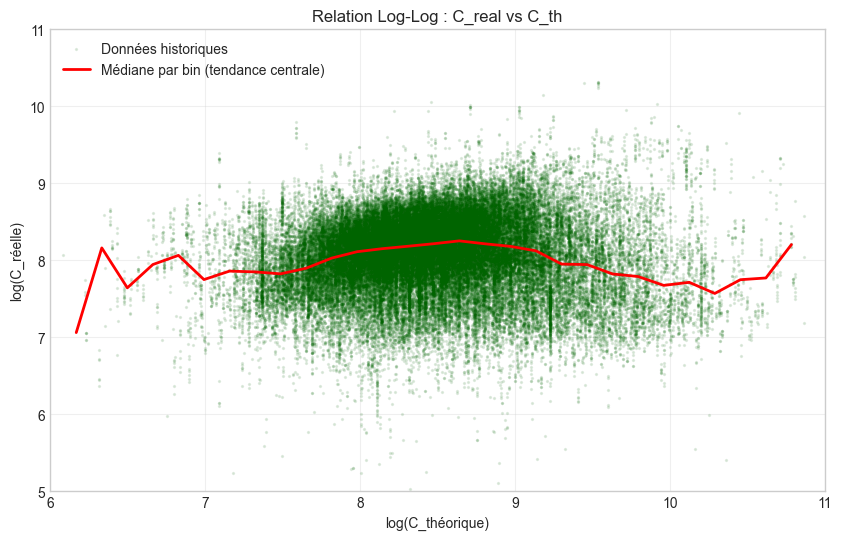

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calcul du log
log_C_th = np.log(df["C_th_elec"])
log_C_real = np.log(df["C_real_elec"])

# Filtrer pour ne garder que le nuage dans la zone d'intérêt
mask = (log_C_th >= 6) & (log_C_th <= 11) & (log_C_real >= 5) & (log_C_real <= 11)
log_C_th_filtered = log_C_th[mask]
log_C_real_filtered = log_C_real[mask]

# Binning pour la médiane (tendance centrale)
bins = np.linspace(log_C_th_filtered.min(), log_C_th_filtered.max(), 30)
bin_indices = np.digitize(log_C_th_filtered, bins)
medians = [log_C_real_filtered[bin_indices == i].median() for i in range(1, len(bins))]

# Position centrale des bins
bin_centers = (bins[:-1] + bins[1:]) / 2

# Graphique
plt.figure(figsize=(10, 6))
plt.scatter(log_C_th_filtered, log_C_real_filtered, alpha=0.1, s=2, color='darkgreen', label="Données historiques")
plt.plot(bin_centers, medians, color='red', linewidth=2, label="Médiane par bin (tendance centrale)")

plt.xlabel("log(C_théorique)")
plt.ylabel("log(C_réelle)")
plt.title("Relation Log-Log : C_real vs C_th")
plt.xlim(6, 11)
plt.ylim(5, 11)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Interprétation :**
Le passage au logarithme linéarise le nuage de points. Cela confirme la pertinence d'un modèle de type puissance $y = a \cdot x^b$. On observe une dispersion constante (homoscédasticité relative), ce qui facilitera la modélisation.

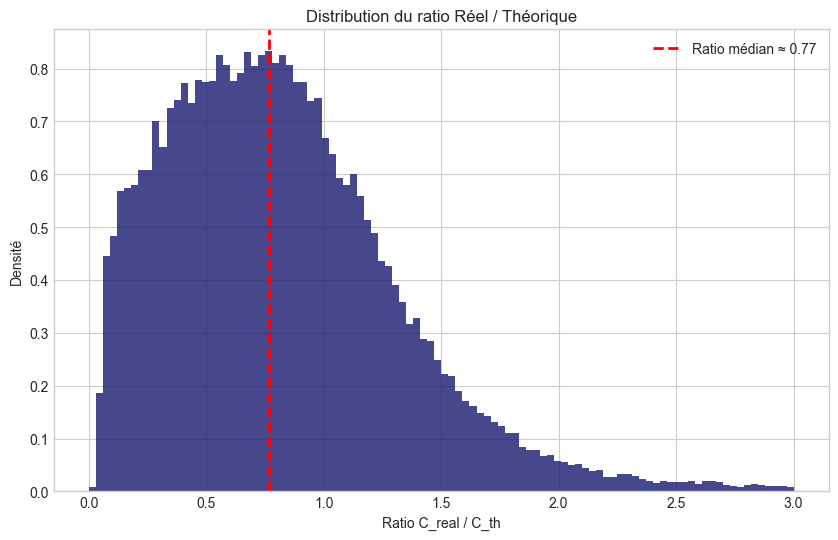

In [30]:
# Ratio
df["Ratio"] = df["C_real_elec"] / df["C_th_elec"]

# Calcul de la médiane
ratio_median = df["Ratio"].median()

plt.figure(figsize=(10, 6))
plt.hist(df[df["Ratio"] < 5]["Ratio"], bins=100, range=(0, 3), density=True,
         color='midnightblue', alpha=0.8)

# Droite verticale à la médiane
plt.axvline(ratio_median, color='red', linestyle='--', linewidth=2,
            label=f"Ratio médian ≈ {ratio_median:.2f}")

plt.xlabel("Ratio C_real / C_th")
plt.ylabel("Densité")
plt.title("Distribution du ratio Réel / Théorique")
plt.legend()
plt.grid(True)
plt.show()


**Interprétation :**
La médiane du ratio est d'environ **0.77** (sur les données électriques). Cela confirme qu'en moyenne, un logement consomme 23% de moins que son étiquette DPE. La distribution est asymétrique avec une queue vers la droite (surconsommations ponctuelles).

## Calibration
Nous calibrons une courbe $C_{real} = a \cdot C_{th}^b$ pour capturer la tendance moyenne = la réponse moyenne des ménages à un besoin énergétique donné. Elle agrège : contraintes économiques, habitudes, sous-chauffage, erreurs du DPE, comportements moyens.

Fonction calibrée (sans bruit) :
C_real = 2021.39 * C_th^0.068


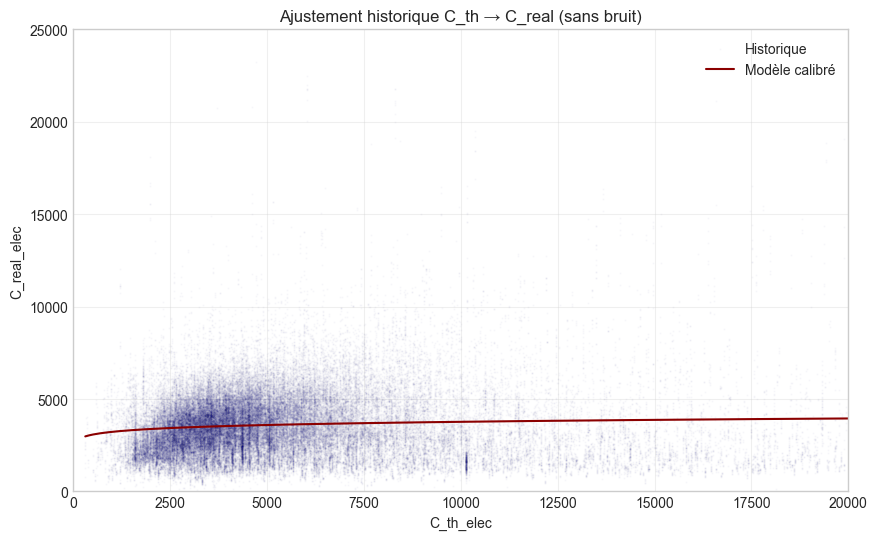

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def modele_puissance(x, a, b):
    return a * x ** b

popt, _ = curve_fit(modele_puissance, df["C_th_elec"], df["C_real_elec"])
a, b = popt

print(f"Fonction calibrée (sans bruit) :")
print(f"C_real = {a:.2f} * C_th^{b:.3f}")

# Tracé plus fin
x_fit = np.linspace(df["C_th_elec"].min(), df["C_th_elec"].max(), 1000)

plt.figure(figsize=(10, 6))
plt.scatter(df["C_th_elec"], df["C_real_elec"], alpha=0.02, s=0.5, color='navy', label="Historique")
plt.plot(x_fit, modele_puissance(x_fit, a, b),
         color="darkred", linewidth=1.5, label="Modèle calibré")
plt.xlabel("C_th_elec")
plt.ylabel("C_real_elec")
plt.title("Ajustement historique C_th → C_real (sans bruit)")
plt.legend()
plt.xlim(0, 20000)
plt.ylim(0, 25000)
plt.grid(True, alpha=0.3)
plt.show()


**Interprétation :**
La courbe rouge représente la consommation réelle **attendue** pour un DPE donné. La courbure (si $b < 1$) illustre l'effet de saturation : plus le logement est théoriquement énergivore, moins les occupants consomment proportionnellement (ils se privent ou chauffent moins).

## Ajout du bruit comportemental (Monte Carlo)

La fonction de calibrage donne une courbe lisse. Or, la réalité est très bruitée (un logement consomme 2x plus qu'un autre identique).
Les diverses études et la littérature énergétique donnent déjà une relation naturelle et logique entre une variable et son coefficient. De plus, une somme entre ces différentes variables est applicable car elles sont indépendantes les unes des autres. Il reste donc à trouver ces coefficients. On effectue ce calibrage à l'aide de l'algorithme de Monte Carlo pour trouver les poids qui expliquent le mieux cette dispersion (=conso_réelle - conso_base).

In [32]:
import pandas as pd
import numpy as np

# --- 1. Copier le df original ---
df_exp = df.copy()

# --- 2. Ne garder que les logements électriques ---
df_exp = df_exp[df_exp['Energie_Principale'] == "Électricité"].copy()

# --- 3. Nettoyage des valeurs manquantes et extrêmes ---
df_exp = df_exp.dropna(subset=['C_real_elec', 'C_th_elec'])
df_exp = df_exp[(df_exp['C_real_elec'] > 100) & (df_exp['C_real_elec'] < 100000)]
df_exp = df_exp[(df_exp['C_th_elec'] > 100) & (df_exp['C_th_elec'] < 100000)]

# --- 4. Créer le ratio observé (utile pour calibrage Monte-Carlo) ---
df_exp['Ratio_Bruit_Obs'] = df_exp['C_real_elec'] / df_exp['C_th_elec']

# --- 5. Encoder la DPE en numérique pour le modèle ---
# On fait un encodage simple A=1, B=2, ..., G=7
dpe_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
df_exp['DPE_Encoded'] = df_exp['DPE'].map(dpe_mapping)

# --- 6. Reset index pour plus de confort ---
df_exp = df_exp.reset_index(drop=True)

# Vérification rapide
print(f"Dataset df_exp : {len(df_exp)} lignes")
df_exp.head()


Dataset df_exp : 92259 lignes


,DPE,C_th_elec,Energie_Principale,C_real_elec,Ratio,Ratio_Bruit_Obs,DPE_Encoded
0,D,3640.4,Électricité,1594.0,0.437864,0.437864,4
1,D,2794.1,Électricité,2861.0,1.023943,1.023943,4
2,F,9042.7,Électricité,4393.0,0.485806,0.485806,6
3,D,1770.9,Électricité,2409.0,1.360325,1.360325,4
4,C,5116.1,Électricité,3338.0,0.652450,0.652450,3


In [33]:
df_exp

,DPE,C_th_elec,Energie_Principale,C_real_elec,Ratio,Ratio_Bruit_Obs,DPE_Encoded
0,D,3640.4,Électricité,1594.0,0.437864,0.437864,4
1,D,2794.1,Électricité,2861.0,1.023943,1.023943,4
2,F,9042.7,Électricité,4393.0,0.485806,0.485806,6
3,D,1770.9,Électricité,2409.0,1.360325,1.360325,4
4,C,5116.1,Électricité,3338.0,0.652450,0.652450,3
...,...,...,...,...,...,...,...
92254,D,4840.7,Électricité,1695.0,0.350156,0.350156,4
92255,B,2438.4,Électricité,2215.0,0.908383,0.908383,2
92256,D,5934.4,Électricité,7447.0,1.254887,1.254887,4
92257,D,5934.4,Électricité,5212.0,0.878269,0.878269,4


In [34]:
from scipy.optimize import minimize
import numpy as np

# Moyenne et variance observées du ratio bruit
obs_mean = df_exp['Ratio_Bruit_Obs'].mean()
obs_variance = df_exp['Ratio_Bruit_Obs'].var()

# --- Fonction de perte pour calibrer les 4 variables de bruit ---
def loss_function_bruit(p):
    """
    p = [delta_temp_coef, nb_occ_coef, presence_coef, bruit_blanc_coef]
    """

    delta_temp_coef, nb_occ_coef, presence_coef, bruit_blanc_coef = p
    N = 100_000

    # Tirage des variables explicatives du bruit
    delta_temp = np.random.uniform(-2, 4, N)
    nb_occ = np.random.randint(0, 4, N)
    presence = np.clip(np.random.normal(0.9, 0.15, N), 0.4, 1.1)
    bruit_blanc = np.random.normal(1.0, 0.05, N)

    # --- Modèle du bruit uniquement ---
    sim_ratio = (
        0.6 * (1 + delta_temp_coef * delta_temp)  # effet température
        + 0.2
        + (nb_occ_coef * nb_occ / 2500)           # effet occupants
        + 0.2
    )

    sim_ratio *= (presence ** presence_coef)      # effet présence
    sim_ratio *= (bruit_blanc ** bruit_blanc_coef)  # bruit résiduel

    # --- Fonction de perte : moments 1 et 2 ---
    loss = (sim_ratio.mean() - obs_mean) ** 2 + (sim_ratio.var() - obs_variance) ** 2
    return loss

# --- Bornes réalistes pour chaque coefficient ---
bounds = [
    (0.008, 0.025),   # delta_temp_coef
    (200, 500),       # nb_occ_coef
    (0.8, 1.2),       # presence_coef
    (0.8, 1.2)        # bruit_blanc_coef (multiplicatif, proche de 1)
]

# Valeurs initiales raisonnables
init_vals = [0.015, 300, 1.0, 1.0]

# --- Optimisation ---
res = minimize(loss_function_bruit, init_vals, bounds=bounds)
calib_delta, calib_occ, calib_presence, calib_bruit = res.x

# --- Affichage des coefficients calibrés ---
print("=== COEFFICIENTS DE BRUIT CALIBRÉS ===")
print(f"Delta Température : {calib_delta:.4f}")
print(f"Occupants         : {calib_occ:.1f} kWh")
print(f"Présence          : {calib_presence:.4f}")
print(f"Bruit Résiduel    : {calib_bruit:.4f}")


=== COEFFICIENTS DE BRUIT CALIBRÉS ===
Delta Température : 0.0150
Occupants         : 300.0 kWh
Présence          : 1.0000
Bruit Résiduel    : 1.0000


=== Vérification rapide des ratios simulés ===
Moyenne simulée  : 0.9749
Variance simulée : 0.0504

=== Variables dominantes identifiées ===
nb_occ               :  54.63 %
presence             :  38.30 %
bruit_blanc          :   5.56 %
delta_temp           :   1.49 %
usage_appareils      :   0.02 %
DPE_Encoded          :   0.00 %


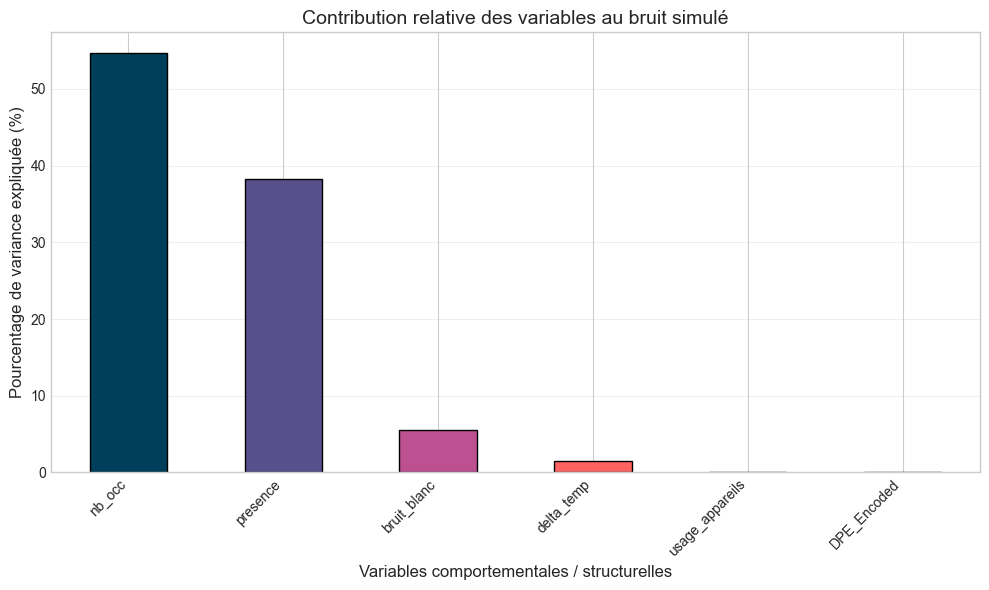

In [35]:
# [B] Monte-Carlo Pré-calibration Réaliste avec plages réalistes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Paramètres de simulation ---
N_SIM = 100_000
np.random.seed(42)

# --- 1. Tirage des variables comportementales réalistes ---
sim_data = pd.DataFrame({
    'delta_temp': np.random.uniform(-5, 5, N_SIM),                  # écart de T° par rapport à 19°C, ±5°C réaliste
    'nb_occ': np.random.randint(0, 6, N_SIM),                        # nombre d'occupants supplémentaires : 0 à 5
    'presence': np.clip(np.random.normal(0.75, 0.1, N_SIM), 0.5, 1.0), # fraction de temps où le logement est occupé
    'usage_appareils': np.random.uniform(0.9, 1.1, N_SIM),           # variation consommation appareils
    'DPE_Encoded': np.random.choice(df_exp['DPE_Encoded'], N_SIM),   # DPE encodé (structure du logement)
    'bruit_blanc': np.random.normal(1.0, 0.05, N_SIM)                # bruit blanc
})

# --- 2. Tirage des coefficients réalistes ---
coeffs_draw = pd.DataFrame({
    'a_temp': np.random.uniform(0.01, 0.03, N_SIM),   # sensibilité chauffage / °C
    'b_occ': np.random.uniform(150, 450, N_SIM),      # kWh par occupant
    'g_pres': np.random.uniform(0.9, 1.1, N_SIM),     # exponent présence
    'e_app': np.random.uniform(0.02, 0.08, N_SIM),   # effet appareils
    'm_dpe': np.random.uniform(-0.003, 0.003, N_SIM) # effet structurel DPE faible
})

# --- 3. Modèle vectorisé du bruit comportemental ---
def fast_model(d, c):
    """
    Modèle de bruit comportemental
    (la consommation DPE n'intervient pas directement)
    """
    ratio = (
        0.6 * (1 + c['a_temp'] * d['delta_temp'])   # effet chauffage
        + 0.2                                      # socle incompressible
        + (c['b_occ'] * d['nb_occ'] / 2500)        # effet occupants
        + 0.2
    )

    ratio *= (d['presence'] ** c['g_pres'])
    ratio *= (d['usage_appareils'] ** c['e_app'])

    # effet structurel très faible lié au DPE
    ratio += c['m_dpe'] * (d['DPE_Encoded'] / 7)

    # bruit blanc final
    ratio *= d['bruit_blanc']

    return ratio

# --- 4. Calcul des ratios simulés ---
sim_ratios = fast_model(sim_data, coeffs_draw)

# --- 5. Vérification globale ---
print("=== Vérification rapide des ratios simulés ===")
print(f"Moyenne simulée  : {sim_ratios.mean():.4f}")
print(f"Variance simulée : {sim_ratios.var():.4f}")

# --- 6. Analyse de sensibilité ---
correlations = []
for col in sim_data.columns:
    r2 = np.corrcoef(sim_data[col], sim_ratios)[0, 1] ** 2
    correlations.append(r2)

sensitivity = pd.Series(correlations, index=sim_data.columns)
sensitivity_pct = 100 * sensitivity / sensitivity.sum()
sensitivity_pct = sensitivity_pct.sort_values(ascending=False)

print("\n=== Variables dominantes identifiées ===")
for var, val in sensitivity_pct.items():
    print(f"{var:<20s} : {val:6.2f} %")

# --- 7. Graphique de sensibilité ---
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600', '#2f4b7c']

plt.figure(figsize=(10,6))
sensitivity_pct.plot(
    kind='bar',
    color=colors[:len(sensitivity_pct)],
    edgecolor='black'
)
plt.title("Contribution relative des variables au bruit simulé", fontsize=14)
plt.ylabel("Pourcentage de variance expliquée (%)", fontsize=12)
plt.xlabel("Variables comportementales / structurelles", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


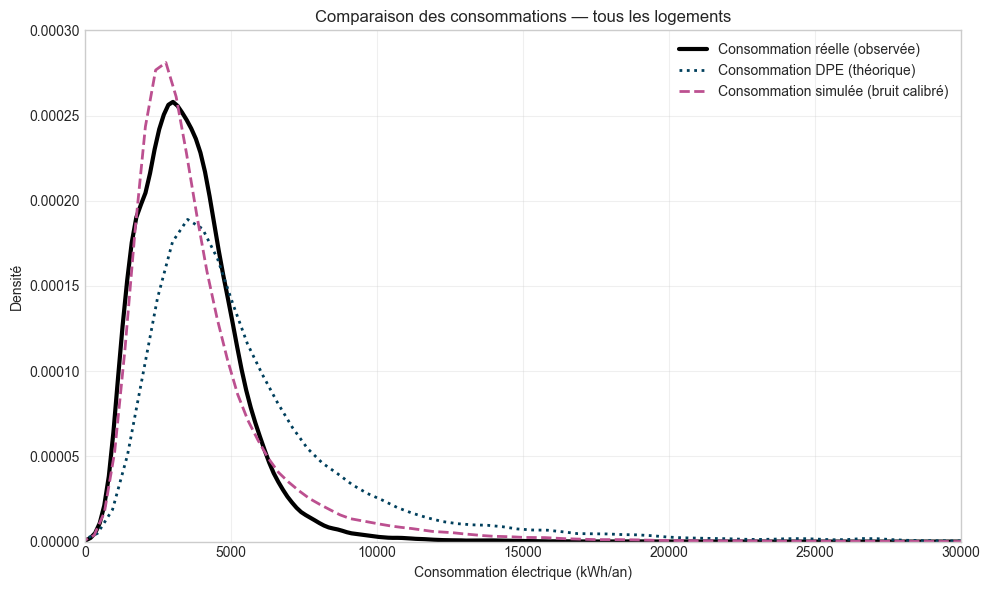

=== Statistiques globales (tous les logements) ===
Réel        → Moyenne : 3589 | Variance : 3039584
DPE         → Moyenne : 5827 | Variance : 21468768
Bruit calibré → Moyenne : 4020 | Variance : 8494872

Paramètres utilisés pour la simulation :
Delta Température      : 0.02 (±5°C)
Nombre d'occupants     : 250.0 kWh / occupant
Taux de présence       : 0.95 (fraction temps occupé)
Élasticité usage app.  : 0.05
Bruit Résiduel          : 1.0


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paramètres calibrés / réalistes du bruit ---
calib_delta = 0.02        # sensibilité température réaliste
calib_occ = 250.0         # kWh par occupant (réaliste)
calib_presence = 0.95     # fraction de présence réaliste
calib_app = 0.05          # élasticité usage appareils
calib_bruit = 1.0         # bruit blanc / résiduel
scaling = 1.0             # facteur global de rescaling

# --- Simulation des variables pour tous les logements ---
N = len(df_exp)

delta_temp      = np.random.uniform(-5, 5, N)                       # ±5°C par rapport à 19°C
nb_occ          = np.random.randint(0, 6, N)                        # 0 à 5 occupants
presence        = np.clip(np.random.normal(0.75, 0.1, N), 0.5, 1.0) # fraction de présence
usage_appareils = np.random.uniform(0.8, 1.2, N)                    # variation usage appareils
bruit_residuel  = np.random.normal(1.0, 0.05, N)                    # bruit blanc

# --- Simulation de la consommation bruitée uniquement ---
C_base = df_exp['C_th_elec']  # consommation théorique de base

C_sim_bruit = (
    0.6 * C_base * (1 + calib_delta * delta_temp)  # effet température
    + 0.2 * C_base                                 # socle incompressible
    + calib_occ * nb_occ                            # effet occupants
)

# Application des élasticités
C_sim_bruit *= (presence ** calib_presence)         # effet présence
C_sim_bruit *= (usage_appareils ** calib_app)      # effet usage appareils
C_sim_bruit *= (bruit_residuel ** calib_bruit)     # bruit résiduel
C_sim_bruit *= scaling                              # facteur global

# --- Tracé KDE pour toutes les consommations ---
plt.figure(figsize=(10,6))

sns.kdeplot(df_exp['C_real_elec'], label='Consommation réelle (observée)', color='black', lw=3)
sns.kdeplot(df_exp['C_th_elec'], label='Consommation DPE (théorique)', color='#003f5c', lw=2, linestyle=':')
sns.kdeplot(C_sim_bruit, label='Consommation simulée (bruit calibré)', color='#bc5090', lw=2, linestyle='--')

plt.title("Comparaison des consommations — tous les logements")
plt.xlabel("Consommation électrique (kWh/an)")
plt.ylabel("Densité")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 30000)
plt.ylim(0, 0.0003)
plt.tight_layout()
plt.show()

# --- Statistiques ---
mean_real = df_exp['C_real_elec'].mean()
var_real  = df_exp['C_real_elec'].var()

mean_th   = df_exp['C_th_elec'].mean()
var_th    = df_exp['C_th_elec'].var()

mean_sim  = C_sim_bruit.mean()
var_sim   = C_sim_bruit.var()

print("=== Statistiques globales (tous les logements) ===")
print(f"Réel        → Moyenne : {mean_real:.0f} | Variance : {var_real:.0f}")
print(f"DPE         → Moyenne : {mean_th:.0f} | Variance : {var_th:.0f}")
print(f"Bruit calibré → Moyenne : {mean_sim:.0f} | Variance : {var_sim:.0f}")

print("\nParamètres utilisés pour la simulation :")
print(f"Delta Température      : {calib_delta} (±5°C)")
print(f"Nombre d'occupants     : {calib_occ} kWh / occupant")
print(f"Taux de présence       : {calib_presence} (fraction temps occupé)")
print(f"Élasticité usage app.  : {calib_app}")
print(f"Bruit Résiduel          : {calib_bruit}")


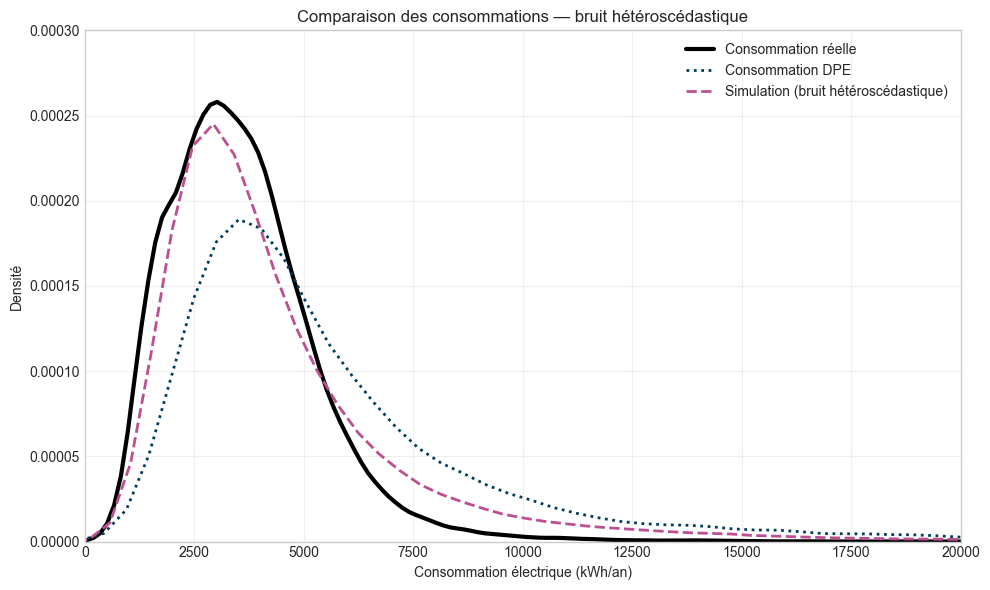

=== Statistiques globales (tous les logements) ===
Réel          → Moyenne : 3589 | Variance : 3039584
DPE           → Moyenne : 5827 | Variance : 21468768
Bruit calibré → Moyenne : 4525 | Variance : 11910387

Paramètres utilisés :
Delta Température      : 0.02
Nombre d'occupants     : 250.0 kWh / occupant
Élasticité présence    : 0.95
Élasticité usage app.  : 0.05
Bruit hétéroscédastique: σ = 0.02 + 1e-06 × C_th


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# ============================
# Paramètres calibrés (fixés)
# ============================
calib_delta = 0.02                 # élasticité température (±5°C)
calib_occ = 250.0                  # kWh / occupant
calib_presence = 0.95              # élasticité présence (REALISTE)
calib_app = 0.05                    # élasticité usage appareils
scaling = 1.0

# Paramètres du bruit hétéroscédastique
sigma_base = 0.02                  # bruit minimal 2 %
sigma_slope = 1.0e-6               # dépendance à C_th

# ============================
# Simulation des variables
# ============================
N = len(df_exp)

delta_temp      = np.random.uniform(-5, 5, N)                        # ±5°C
nb_occ          = np.random.randint(0, 4, N)                         # 0 à 3 occupants
presence        = np.clip(np.random.normal(0.9, 0.15, N), 0.4, 1.1)  # fraction de présence
usage_appareils = np.random.uniform(0.8, 1.2, N)                     # variation usage appareils

C_base = df_exp['C_th_elec']

# ============================
# Bruit hétéroscédastique
# ============================
sigma_i = sigma_base + sigma_slope * C_base
bruit_residuel = np.random.normal(1.0, sigma_i)

# ============================
# Consommation simulée (BRUIT UNIQUEMENT)
# ============================
C_sim_bruit = (
    0.6 * C_base * (1 + calib_delta * delta_temp)
    + 0.2 * C_base
    + calib_occ * nb_occ
)

# Application des élasticités
C_sim_bruit *= presence ** calib_presence
C_sim_bruit *= usage_appareils ** calib_app
C_sim_bruit *= bruit_residuel
C_sim_bruit *= scaling

# ============================
# KDE COMPARATIF
# ============================
plt.figure(figsize=(10, 6))

sns.kdeplot(df_exp['C_real_elec'],
            label='Consommation réelle',
            color='black', lw=3)

sns.kdeplot(df_exp['C_th_elec'],
            label='Consommation DPE',
            color='#003f5c', lw=2, linestyle=':')

sns.kdeplot(C_sim_bruit,
            label='Simulation (bruit hétéroscédastique)',
            color='#bc5090', lw=2, linestyle='--')

plt.title("Comparaison des consommations — bruit hétéroscédastique")
plt.xlabel("Consommation électrique (kWh/an)")
plt.ylabel("Densité")
plt.grid(alpha=0.3)
plt.legend()

plt.xlim(0, 20000)
plt.ylim(0, 0.0003)
plt.tight_layout()
plt.show()

# ============================
# Statistiques globales
# ============================
print("=== Statistiques globales (tous les logements) ===")
print(f"Réel          → Moyenne : {df_exp['C_real_elec'].mean():.0f} | Variance : {df_exp['C_real_elec'].var():.0f}")
print(f"DPE           → Moyenne : {df_exp['C_th_elec'].mean():.0f} | Variance : {df_exp['C_th_elec'].var():.0f}")
print(f"Bruit calibré → Moyenne : {C_sim_bruit.mean():.0f} | Variance : {C_sim_bruit.var():.0f}")

print("\nParamètres utilisés :")
print(f"Delta Température      : {calib_delta}")
print(f"Nombre d'occupants     : {calib_occ} kWh / occupant")
print(f"Élasticité présence    : {calib_presence}")
print(f"Élasticité usage app.  : {calib_app}")
print(f"Bruit hétéroscédastique: σ = {sigma_base} + {sigma_slope} × C_th")


In [38]:
C_sim_bruit = (
    (0.6 * C_base * (1 + calib_delta * delta_temp)    # effet température
     + 0.2 * C_base                                   # socle incompressible
     + calib_occ * nb_occ)                             # effet occupants
    * presence ** calib_presence                        # effet présence
    * bruit_residuel                                   # bruit hétéroscédastique
)

Démarrage de l'optimisation MLE...
Succès: True | NLL final: 864368.42
Coeffs: Delta=0.003, Occ=666.1, Pres=3.08, App=0.11, Sigma=2835.6

--- Performance Cas par Cas ---
[Initial] MAE: 2100 kWh | RMSE: 3378 kWh | R²: -2.754
[Optimisé (MLE)] MAE: 2084 kWh | RMSE: 2836 kWh | R²: -1.645


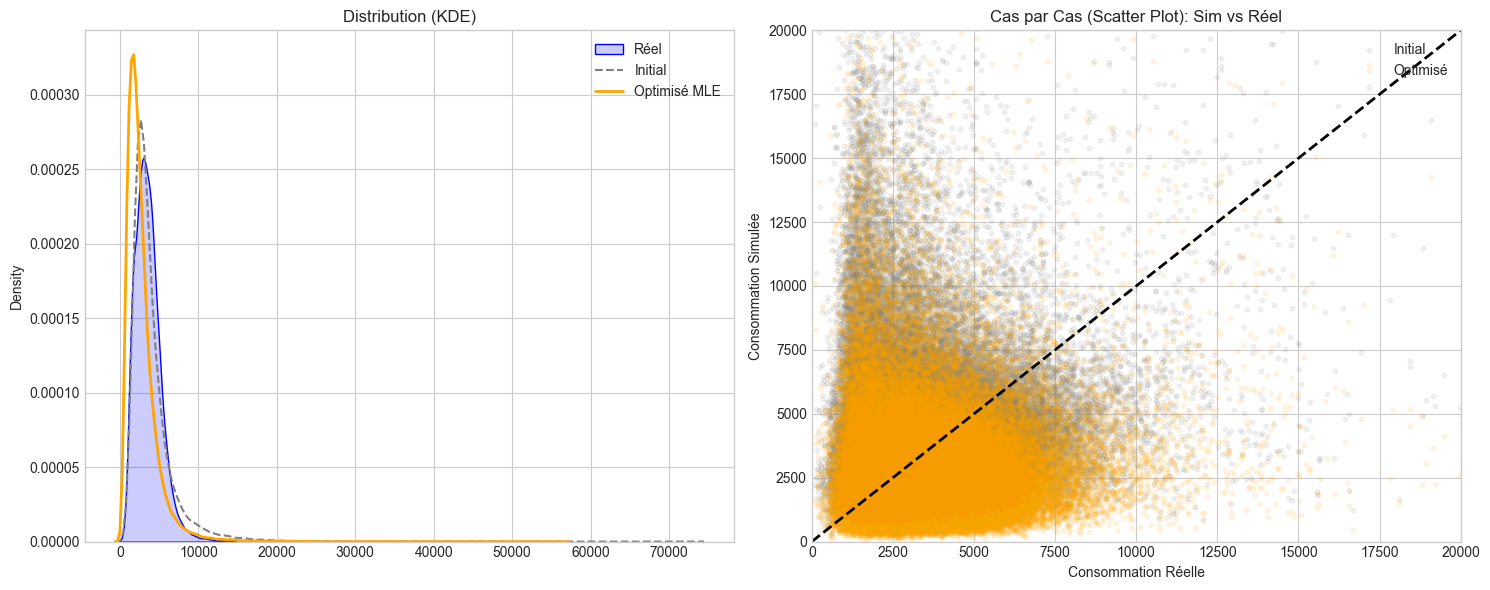

In [39]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fixer la graine pour la reproductibilité
np.random.seed(42)

# --- 1. Préparation des données ---
# On récupère les données réelles et théoriques
C_real = df['C_real_elec'].values
C_th = df['C_th_elec'].values
n_samples = len(df)

# Génération des variables aléatoires (FIXES pour l'optimisation)
delta_temp = np.random.uniform(-5, 5, n_samples)
nb_occ = np.random.randint(0, 6, n_samples)
presence = np.clip(np.random.normal(0.75, 0.1, n_samples), 0.5, 1.0)
usage_appareils = np.random.uniform(0.8, 1.2, n_samples)
bruit_residuel = np.random.normal(1.0, 0.05, n_samples)

# --- 2. Définition du modèle ---
def get_C_sim(calib_delta, calib_occ, calib_presence, calib_app, calib_bruit, scaling):
    term_chauffage = 0.6 * C_th * (1 + calib_delta * delta_temp)
    term_base = 0.2 * C_th
    term_occ = calib_occ * nb_occ
    facteurs = (presence ** calib_presence) * (usage_appareils ** calib_app) * bruit_residuel
    C_sim = (term_chauffage + term_base + term_occ) * facteurs * scaling
    return C_sim

# --- 3. Fonction de coût (NLL) ---
def neg_log_likelihood(params):
    c_delta, c_occ, c_pres, c_app, sigma = params
    C_sim_pred = get_C_sim(c_delta, c_occ, c_pres, c_app, 1.0, 1.0)
    residuals = C_real - C_sim_pred
    if sigma <= 1e-3: return np.inf
    n = len(residuals)
    nll = (n / 2) * np.log(2 * np.pi * sigma**2) + np.sum(residuals**2) / (2 * sigma**2)
    return nll

# --- 4. Optimisation ---
sigma_init = np.std(C_real - C_th)
x0 = [0.02, 250.0, 0.95, 0.05, sigma_init]
bounds = [(-0.2, 0.2), (0, 1000), (0, 5), (0, 5), (1e-1, None)]

print("Démarrage de l'optimisation MLE...")
res = minimize(neg_log_likelihood, x0, method='L-BFGS-B', bounds=bounds)
c_delta_opt, c_occ_opt, c_pres_opt, c_app_opt, sigma_opt = res.x

print(f"Succès: {res.success} | NLL final: {res.fun:.2f}")
print(f"Coeffs: Delta={c_delta_opt:.3f}, Occ={c_occ_opt:.1f}, Pres={c_pres_opt:.2f}, App={c_app_opt:.2f}, Sigma={sigma_opt:.1f}")

# --- 5. Calcul des Métriques (Cas par Cas) ---
sim_init = get_C_sim(*x0[:-1], 1.0, 1.0)
sim_opt = get_C_sim(c_delta_opt, c_occ_opt, c_pres_opt, c_app_opt, 1.0, 1.0)

def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.0f} kWh | RMSE: {rmse:.0f} kWh | R²: {r2:.3f}")

print("\n--- Performance Cas par Cas ---")
print_metrics("Initial", C_real, sim_init)
print_metrics("Optimisé (MLE)", C_real, sim_opt)

# --- 6. Visualisation Complète ---
plt.figure(figsize=(15, 6))

# KDE (Distribution)
plt.subplot(1, 2, 1)
sns.kdeplot(C_real, fill=True, label='Réel', color='blue', alpha=0.2)
sns.kdeplot(sim_init, label='Initial', color='gray', linestyle='--')
sns.kdeplot(sim_opt, label='Optimisé MLE', color='orange', linewidth=2)
plt.title('Distribution (KDE)')
plt.legend()

# Scatter (Cas par Cas)
plt.subplot(1, 2, 2)
plt.scatter(C_real, sim_init, alpha=0.1, color='gray', label='Initial', s=10)
plt.scatter(C_real, sim_opt, alpha=0.1, color='orange', label='Optimisé', s=10)
plt.plot([0, 20000], [0, 20000], 'k--', lw=2)
plt.xlim(0, 20000); plt.ylim(0, 20000)
plt.title('Cas par Cas (Scatter Plot): Sim vs Réel')
plt.xlabel('Consommation Réelle')
plt.ylabel('Consommation Simulée')
plt.legend()

plt.tight_layout()
plt.show()


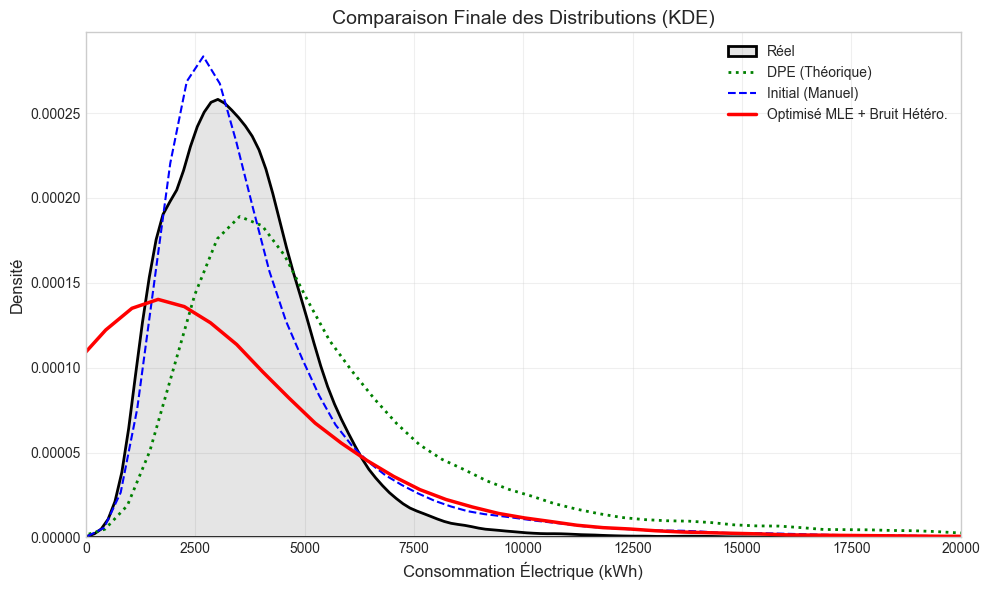

Bruit Hétéroscédastique appliqué : sigma = 1417.78 + 0.51464 * C_sim


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des données nécessaires (en supposant que les cellules précédentes ont été exécutées)
# - C_real, C_th, n_samples
# - sim_opt (la simulation optimisée par MLE sans bruit supplémentaire)
# - sigma_opt (l'écart-type global optimisé)
# - sigma_init (l'écart-type initial)

# --- 1. Définition du Bruit Hétéroscédastique ---
# Hypothèse : La variance du bruit augmente avec la consommation théorique.
# Sigma = base + slope * C_sim_opt
# On peut calibrer slope pour que sigma moyen corresponde à sigma_opt

sigma_base = sigma_opt * 0.5  # Part fixe du bruit
sigma_slope = (sigma_opt * 0.5) / np.mean(sim_opt) # Part proportionnelle

# Calcul de l'écart-type local pour chaque point
sigma_hetero = sigma_base + sigma_slope * sim_opt

# Génération du bruit
np.random.seed(42)
noise_hetero = np.random.normal(0, sigma_hetero, n_samples)

# Simulation finale avec bruit hétéroscédastique (ADDITIF sur la base optimisée)
sim_final_hetero = sim_opt + noise_hetero

# Pour comparaison, on reprend sim_init (simulation initiale)
# et sim_opt (simulation optimisée structurelle, sans le bruit aléatoire ajouté ici)

# --- 2. Visualisation KDE (Uniquement) ---
plt.figure(figsize=(10, 6))

# Consommation Réelle
sns.kdeplot(C_real, fill=True, label='Réel', color='black', alpha=0.1, linewidth=2)

# Consommation DPE
sns.kdeplot(C_th, label='DPE (Théorique)', color='green', linestyle=':', linewidth=2)

# Simulation Initiale (Coefficients manuels)
sns.kdeplot(sim_init, label='Initial (Manuel)', color='blue', linestyle='--')

# Simulation Optimisée MLE + Bruit Hétéroscédastique
sns.kdeplot(sim_final_hetero, label='Optimisé MLE + Bruit Hétéro.', color='red', linewidth=2.5)

plt.title('Comparaison Finale des Distributions (KDE)', fontsize=14)
plt.xlabel('Consommation Électrique (kWh)', fontsize=12)
plt.ylabel('Densité', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 20000) # Focus sur la partie principale
plt.tight_layout()
plt.show()

print(f"Bruit Hétéroscédastique appliqué : sigma = {sigma_base:.2f} + {sigma_slope:.5f} * C_sim")
